## 2. Constraint Satisfaction Problems

First, we wanted add every bit of information we got from the assingment and create a easy representation for us. So we can later use them in our constraints easily and declaratively, removing the need for any magic numbers/variables.

We also created a distinct name for each group from each major, so we can later identify and check that we are not missing out or assigning the same group multiple times either than needed or at the same time.


#### Define Static Variables

In [28]:


# Define all static variables from the assignment description
rooms = ["L1", "L2", "L3"]
time_slots = ["8-9", "10-11", "13-14", "15-16"]
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
num_presentations_needed = 3
num_max_commitee_room_changes_per_day = 2

#### Load Data from CSV

In [29]:
from csv import DictReader


def load_data_from_csv(filepath):
    """Load data from CSV file"""
    courses = {}

    with open(filepath, 'r', encoding='utf-8') as file:
        reader = DictReader(file, delimiter=';')

        for row in reader:
            major = row['Studiengang']
            courses[major] = {
                'num_groups': int(row['Projektgruppen']),
                'num_committees': int(row['Kommissionen']),
                'groups': [f'{major}-G{i + 1}' for i in range(int(row['Projektgruppen']))],
                'committees': [f'{major}-C{i + 1}' for i in range(int(row['Kommissionen']))],
            }

    total_presentations = sum(course['num_groups'] * 3 for course in courses.values())
    max_possible_presentations = len(rooms) * len(time_slots) * len(days)
    if total_presentations > max_possible_presentations:
        raise ValueError('Invalid number of presentations. Unsolvable in this timeframe')
    return courses

#### Create and Solve the Problem

In [ ]:
from constraint import Problem, RecursiveBacktrackingSolver


def solve(filepath):
    courses = load_data_from_csv(filepath)

    problem = Problem()

    # All presentation names while creating variables
    all_presentations = []

    for course, data in courses.items():
        for group in data['groups']:
            for p in range(1, num_presentations_needed + 1):
                var_name = f"{group}-P{p}"
                problem.addVariable(f'{var_name}-day', days)
                problem.addVariable(f'{var_name}-room', rooms)
                problem.addVariable(f"{var_name}-slot", time_slots)
                problem.addVariable(f"{var_name}-committee", data['committees'])
                all_presentations.append(var_name)
    print(f'Added {len(all_presentations) * 4} variables')

    def no_room_overlaps(day1, room1, slot1, day2, room2, slot2):
        return not (day1 == day2 and room1 == room2 and slot1 == slot2)

    for i in range(len(all_presentations)):
        for j in range(i + 1, len(all_presentations)):
            pres1 = all_presentations[i]
            pres2 = all_presentations[j]
            problem.addConstraint(
                no_room_overlaps,
                (f'{pres1}-day', f'{pres1}-room', f'{pres1}-slot',
                 f'{pres2}-day', f'{pres2}-room', f'{pres2}-slot')
            )

    def presentation_order(day1, slot1, day2, slot2, day3, slot3):
        """P1 < P2 < P3 chronologically"""
        time_order = {day: idx for idx, day in enumerate(days)}
        slot_order = {slot: idx for idx, slot in enumerate(time_slots)}

        t1 = time_order[day1] * len(time_slots) + slot_order[slot1]
        t2 = time_order[day2] * len(time_slots) + slot_order[slot2]
        t3 = time_order[day3] * len(time_slots) + slot_order[slot3]

        return t1 < t2 < t3

    for course, data in courses.items():
        for group in data['groups']:
            p1, p2, p3 = [f"{group}-P{i}" for i in [1, 2, 3]]
            problem.addConstraint(
                presentation_order,
                (f'{p1}-day', f'{p1}-slot',
                 f'{p2}-day', f'{p2}-slot',
                 f'{p3}-day', f'{p3}-slot')
            )

    problem.setSolver(RecursiveBacktrackingSolver())
    return problem.getSolutions()


solution = solve("DS_CSP_1/pr_conf_000.csv")

Added 60 variables


#### Display Solution as Timetable

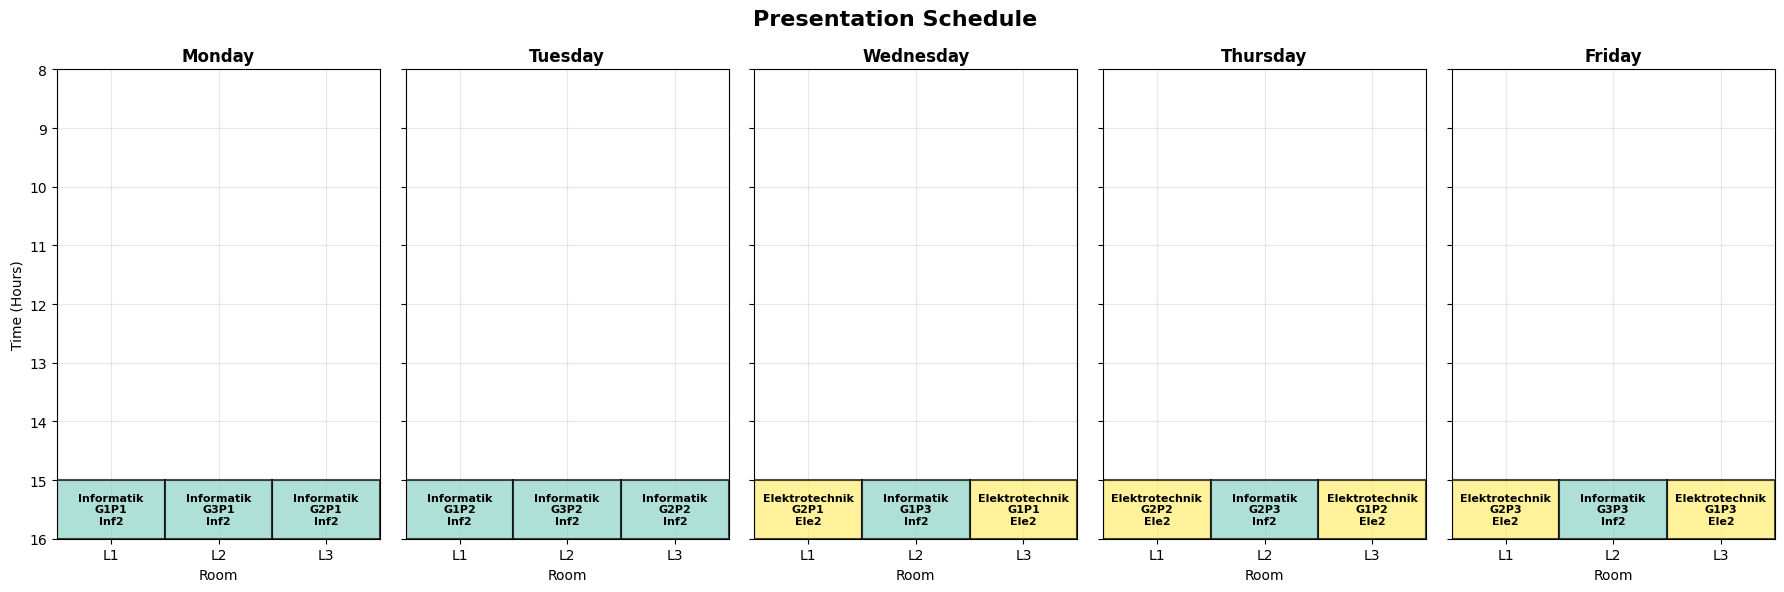

In [55]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np


def display_timetable(solution):
    """Display the solution as a matplotlib plot"""
    if solution is None:
        print("No solution found!")
        return

    # Parse solution and organize presentations
    presentations = {}
    for var_name, value in solution.items():
        parts = var_name.rsplit('-', 1)
        pres_name = parts[0]
        attribute = parts[1]

        if pres_name not in presentations:
            presentations[pres_name] = {}
        presentations[pres_name][attribute] = value

    # Create figure
    fig, axes = plt.subplots(1, len(days), figsize=(18, 6), sharey=True)
    fig.suptitle('Presentation Schedule', fontsize=16, fontweight='bold')

    # Color map for different majors
    majors = list(set(p.split('-')[0] for p in presentations.keys()))
    colors = plt.cm.Set3(np.linspace(0, 1, len(majors)))
    major_colors = {major: colors[i] for i, major in enumerate(majors)}

    for day_idx, day in enumerate(days):
        ax = axes[day_idx]
        ax.set_title(day, fontweight='bold')
        ax.set_xlim(0, len(rooms))
        ax.set_ylim(8, 16)
        ax.set_xticks(np.arange(len(rooms)) + 0.5)
        ax.set_xticklabels(rooms)
        ax.set_xlabel('Room')

        if day_idx == 0:
            ax.set_yticks(range(8, 17))
            ax.set_ylabel('Time (Hours)')

        ax.grid(True, alpha=0.3)
        ax.set_axisbelow(True)
        ax.invert_yaxis()

        # Plot presentations
        for pres_name, attrs in presentations.items():
            if attrs['day'] == day:
                room_idx = rooms.index(attrs['room'])

                # Dynamically parse time slot to get start and end hour
                start_hour, end_hour = map(int, attrs['slot'].split('-'))

                # Shorten committee name: e.g., "INF-C1" -> "INFC1"
                committee = attrs['committee']
                committee_short = committee[:3] + committee.split('-C')[1]

                course_name = pres_name.split('-')[0]

                # Extract group info: e.g., "INF-G1-P1" -> "G1P1"
                group_info = pres_name.split('-')[1] + pres_name.split('-')[2]

                major = pres_name.split('-')[0]
                color = major_colors[major]

                # Draw rectangle between the hours
                rect = Rectangle((room_idx, start_hour), 1, end_hour - start_hour,
                                 linewidth=1.5, edgecolor='black',
                                 facecolor=color, alpha=0.7)
                ax.add_patch(rect)

                # Add text in the center
                text = f"{course_name}\n{group_info}\n{committee_short}"
                ax.text(room_idx + 0.5, (start_hour + end_hour) / 2, text,
                        ha='center', va='center', fontsize=8, fontweight='bold')

    plt.tight_layout()
    plt.show()


print(f"Found {len(solution)} solutions:")
display_timetable(solution[0])